Classification Under Open Set Conditions
===

Author: Nathan A. Mahynski

Date: 2023/08/31

Description: Building classifiers that work in the "open world."

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/opensetclassification.ipynb)

Conventional classifiers often assume there exist a finite set of known classes.

$$C_{\rm assumed} = [C_1, C_2, C_3]$$

To train such a model, these classes should be sampled (often evenly) in such a way that during testing / deployment the new observations will come from the same distribution as the training samples (IID).  Class balancing and cross-validation are common tools used to handle uncertainty in the latter of these assumptions, however, in the real world there are often many other (possibly infinite number of) classes that are not available at training time which a classifier might encounter when deployed.  

$$C_{\rm reality} = [C_1, C_2, C_3, \dots)$$

This image is from [Scheirer et al., "Toward Open Set Recognition" (2012)](https://ieeexplore.ieee.org/abstract/document/6365193) which originally formalized the open set recognition (OSR) problem:

<img src="https://github.com/mahynski/pychemauth/blob/main/docs/_static/osr_definition.png?raw=1" style="width:500px;">

Note that the "face verification" problem is essentially a one-class authentication problem. This "open set" of possibilities means that a classifier should be able to recognize the known classes seen during training, but also recognize when a test case is "none of the above."  There are a variety of algorithms designed to do this and related tasks.  Here a few references that summarize some ontologies:

1. [Yang et al., Generalized Out-of-Distribution Detection: A Survey](https://arxiv.org/abs/2110.11334)
2. [Geng et al., Recent Advances in Open Set Recognition: A Survey](https://ieeexplore.ieee.org/abstract/document/9040673)

The OSR task refers to when the model should be able to identify known classes and reject unknown ones.  By some classification schemes, the process of simply rejecting an input as being from an unknown class is referred to as a "reject" option.  OSR tasks are closely related to one-class classifiers (OCC) used for authentication purposes.  An OSR-capable model can be constructed by chaining together multiple OCCs, each designed to recognize a single class.  [Soft PLS-DA](../learn/plsda.ipynb) is another example of model capable of handling open-set conditions. Another *ad hoc*, but general, way to handle an OSR task is to combine an outlier detector with a closed set classifier (blue pathway below). Green and red pathways illustrate ["compliant" and "rigorous"](simca.ipynb#Building-an-Authenticator) OCC training schemes, respectively.  The "pipeline" is any composite model, possibly including other preprocessing steps.

<img src="https://github.com/mahynski/pychemauth/blob/main/docs/_static/osr.png?raw=1" style="width:250px;">

The outlier detector illustrated here determines if a sample is out of distribution (OOD), and sends only those in distribution (ID) to the classifier.  In this way, the outlier detector determines if the input is coming from a "known" region of parameter space which the classifier should be responsible for.  If not, the input is simply assigned to an "unknown" class.  Otherwise, the closed-set classifier is assumed to be responsible for identifying the input as one of its known classes.  The outlier detector itself may use a variety of different assumptions depending on which detector is used, as may the classifier, but this combination method is very general and can be applied with different sorts of outlier detectors and classification models.

We have implemented a basic `OpenSetClassifier` model in PyChemAuth which we illustrate for a variety of different conditions below. Depending on the classification model being used the performance metric may vary.  

The `OpenSetClassifier` works as follows:
1. Select known classes to use from training data (typically all that are available).
2. Send knowns to outlier detector (OD) to train it.
3. Use fitted OD to predict inliers on training data.
4. Send inlying, known class examples to classifier to train on.

During test time, new samples are first given to the OD; if considered an inlier, then the classifier is called to identify the sample, otherwise it is labeled as "unknown".

Note that if the underlying classification model is capable of detecting outliers (or rejecting acceptance, as in OCC) we should be able to combine those (1) rejected because the test sample belongs to an known alternative ("known unknown") with those (2) rejected because they are from an unknown alternative class ("unknown unknown") to compute performance metrics.  Sometimes it is useful to avoid this to identify why a sample was rejected (by the model or the outlier detector?).  Examples of this are illustrated below.

There are many classification models available in both PyChemAuth and [scikit-learn](https://scikit-learn.org/stable/index.html); the latter also offers various [outlier detection routines](https://scikit-learn.org/stable/modules/outlier_detection.html), but there are many more available in compatbile libraries such as [pyOD](https://pyod.readthedocs.io/en/latest/).

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [1]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import sklearn
import numpy as np
from pychemauth.classifier.osr import OpenSetClassifier
from pychemauth.classifier.plsda import PLSDA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from pychemauth.manifold.elliptic import EllipticManifold_Model
from pychemauth.classifier.simca import SIMCA_Authenticator

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

matplotlib: 3.7.2
numpy     : 1.24.3
watermark : 2.4.3
pychemauth: 0.0.0b4
sklearn   : 1.3.0



Load Example Data
---

In [4]:
from sklearn.datasets import load_iris as load_data
X, y = load_data(return_X_y=True, as_frame=True)

# Let's turn the indices into names
names = dict(zip(np.arange(3), ['setosa', 'versicolor', 'virginica']))
y = y.apply(lambda x: names[x])

X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values,
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

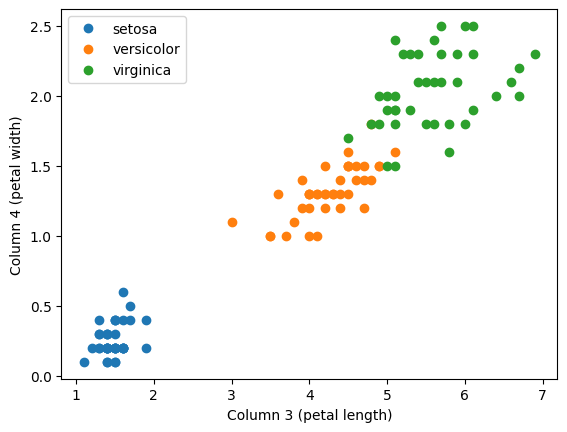

In [6]:
for class_ in ['setosa', 'versicolor', 'virginica']:
    mask = y_train == class_
    plt.plot(X_train[mask][:,2], X_train[mask][:,3], 'o', label=class_)
plt.xlabel('Column 3 (petal length)')
plt.ylabel('Column 4 (petal width)')
_ = plt.legend(loc='best')

# Case 1: Multiclass Hard Model

Hard models divide the input / latent space into disjoint regions for each known class.  By adding an outlier detector (OD), we can effectively turn this discriminator into a class model that uses OD to create finite regions of space in which we should expect the hard model to work correctly.

Recall from [our example using PLS-DA](plsda.ipynb), that hard PLS-DA with 3 components (and other hyperparamters below) has a 2D space which can divide the three iris flowers reasonably well.  Here, let's just train with 2 classes to emulate the case where we have an incomplete knowledge of all possible flowers.

In [7]:
# Leave out versicolor on purpose
X_train_ = X_train[y_train != 'versicolor']
y_train_ = y_train[y_train != 'versicolor']

## Case 1a: Using a Flexible Outlier Detector

Here we will use an [isolation forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest) to detect outliers.  The advantage of this model is that it does not make assumptions about the underlying distribution of the data.  This is important if the data is **multimodal** (for example, if you have multiple classes and each has a different center) so for multiclass problems this is recommended.  See [this example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py) for an illustration of how isolation forest works.

The main assumption with an isolation forest is that there are dense cluster(s) of data which determine where "inliers" should be located.  This is a reasonable assumption for many chemometric authentication problems.

In [8]:
osc = OpenSetClassifier(
    clf_model=PLSDA,
    clf_kwargs={
        'n_components':3,
        'alpha':0.05,
        'gamma':0.01,
        'style':"hard",
        'scale_x':True,
    },
    outlier_model=IsolationForest,
    outlier_kwargs={
        'n_estimators':100,
        'max_samples':1.0,
        'contamination': 0.15, # In practice, this is very important to tune correctly
        'max_features':1.0,
        'bootstrap':True,
        'random_state':42,
    },
    score_metric='TEFF',
    clf_style='hard',
    unknown_class="UNKNOWN FLOWER",
)

In [9]:
osc.fit(X_train_, y_train_)

OpenSetClassifier(clf_kwargs={'alpha': 0.05, 'gamma': 0.01, 'n_components': 3,
                              'scale_x': True, 'style': 'hard'},
                  clf_model=<class 'pychemauth.classifier.plsda.PLSDA'>,
                  outlier_kwargs={'bootstrap': True, 'contamination': 0.15,
                                  'max_features': 1.0, 'max_samples': 1.0,
                                  'n_estimators': 100, 'random_state': 42},
                  outlier_model=<class 'sklearn.ensemble._iforest.IsolationForest'>,
                  unknown_class='UNKNOWN FLOWER')

In [10]:
osc.predict(X_train_)[:10]

['setosa',
 'UNKNOWN FLOWER',
 'setosa',
 'virginica',
 'virginica',
 'virginica',
 'UNKNOWN FLOWER',
 'virginica',
 'setosa',
 'setosa']

In [11]:
res = osc.figures_of_merit(osc.predict(X_train_), y_train_)

In [12]:
osc.score(X_train_, y_train_)

0.9219544457292888

In [13]:
res['TEFF']

0.9219544457292888

In [14]:
res['CM']

,setosa,virginica,UNKNOWN FLOWER
setosa,35,0,5
virginica,0,33,7


In [15]:
# The isolation forest tuned itself to find this fraction of unknowns.
res['CM']['UNKNOWN FLOWER'].sum() / (40 + 40)

0.15

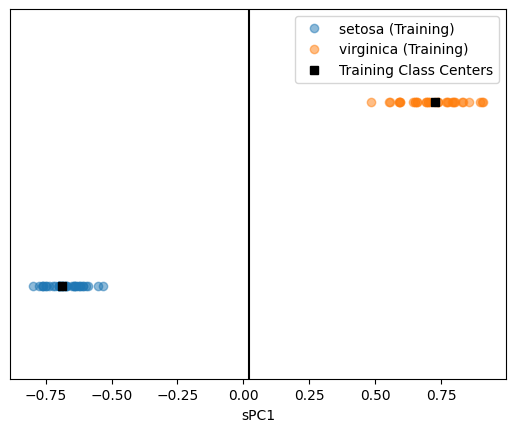

In [16]:
# The underlying hard model only recognizes setosa and virginica
_ = osc.fitted_classification_model.visualize(styles=['hard'])

In [17]:
# And it can only predict membership to setosa and virginica

print('Inlier?\tPrediction\tActual')
print('------------------------------')
for inlier, pred, act in zip(
    osc.fitted_outlier_model.predict(X_train_)[:10],
    osc.fitted_classification_model.predict(X_train_)[:10],
    y_train_[:10]
):
    print(inlier, '\t', pred, '\t', act)

Inlier?	Prediction	Actual
------------------------------
1 	 setosa 	 setosa
-1 	 virginica 	 virginica
1 	 setosa 	 setosa
1 	 virginica 	 virginica
1 	 virginica 	 virginica
1 	 virginica 	 virginica
-1 	 virginica 	 virginica
1 	 virginica 	 virginica
1 	 setosa 	 setosa
1 	 setosa 	 setosa


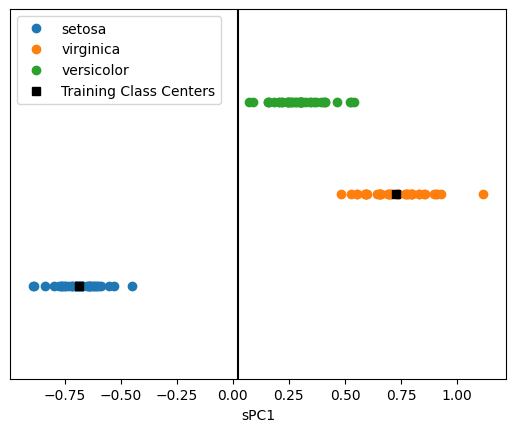

In [18]:
# Clearly nearly all the intervening versicolor (green) will be classified incorrectly as virginica (orange).

fig, ax = plt.subplots(nrows=1, ncols=1)

for i, class_ in enumerate(['setosa', 'virginica', 'versicolor']):
    mask = y_train == class_

    projection = osc.fitted_classification_model.transform(X_train[mask])
    ax.plot(projection.ravel(), [i]*projection.shape[0], 'o', label=class_)

ax = osc.fitted_classification_model.visualize(styles=['hard'], ax=ax, show_training=False)
_ = ax.legend(loc='best')
_ = ax.set_ylim(-1, 3)

Text(0, 0.5, 'Column 4 (petal width)')

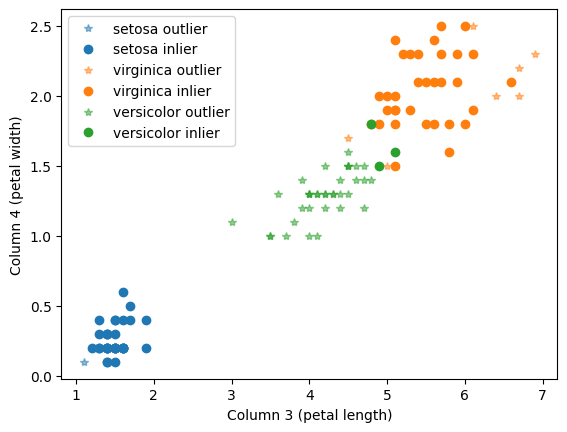

In [19]:
for i, label in enumerate(['setosa', 'virginica', 'versicolor']):
    mask = y_train == label
    X_ = X_train[mask]
    inlier_ = osc.fitted_outlier_model.predict(X_)

    for marker, alpha, value in zip(['*', 'o'], [0.5, 1.0], [-1, +1]):
        out_mask = inlier_ == value
        plt.plot(X_[out_mask, 2], X_[out_mask, 3], marker=marker, lw=0, alpha=alpha, label=f'{label} {"inlier" if value==1 else "outlier"}', color=f'C{i}')
plt.legend(loc='upper left')
plt.xlabel('Column 3 (petal length)')
plt.ylabel('Column 4 (petal width)')

In [20]:
# However, the OSC model is able to identify most of the versicolor samples as being from an unknown class!

res = osc.figures_of_merit(osc.predict(X_train), y_train)
res['CM']

,setosa,virginica,UNKNOWN FLOWER
setosa,35,0,5
versicolor,0,3,37
virginica,0,33,7


---
> ❗ If you change the contamination parameter, you can get very different results.  For example, try 0.05 instead of 0.15.
---

## Case 1b: Using an Outlier Detector with Strong Assumptions

Here we will use an elliptical manifold to determine if a point is an outlier or inlier.  This is akin to using the robust covariance approach illustrated [here](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py) and assumes that the inlying data is all located inside a single "ellipse".  For one-class classification instances, this can be reasonable, but **should be avoided for multiclass problems** since this will draw an ellipse around multiple class centers, possibly overlapping the region "in between" which makes the model susceptible to issues if there are alternative classes there.  In this example data, the versicolor class tends to be "in between" the other 2 and nicely demonstrates the issue.

In [21]:
# If we do not provide a dr_model then the EllipticManifold simply fits an ellipse in the original data space.
# For this example, let's just use the second 2 columns so that we will be able to plot the results nicely.

setosa_virginica = EllipticManifold_Model(
    alpha=0.05,
    robust=True, # Estimate the covariance matrix for the Mahalanobis distance using a robust approach (MCD)
    center='score', # Center the ellipse around the empirical mean of the projected data
)

_ = setosa_virginica.fit(
    X_train_[:, 2:],
    ["INLIERS"] * np.sum(y_train != 'versicolor')
)

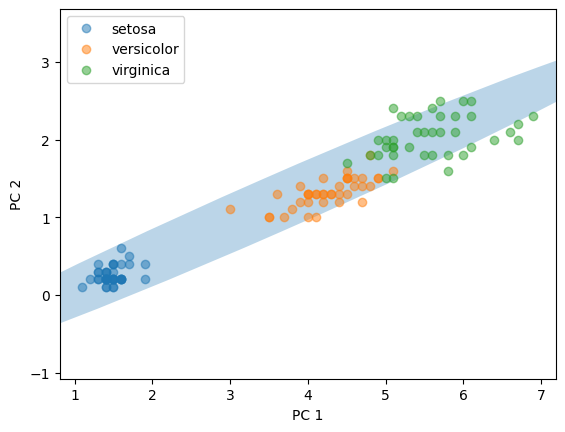

In [22]:
# Clearly, the versicolor falls between the other 2, so this elliptical boundary is not expected to be a good outlier
# detector.

_ = setosa_virginica.visualize(
    [
        X_train[y_train == 'setosa'][:, 2:],
        X_train[y_train == 'versicolor'][:, 2:],
        X_train[y_train == 'virginica'][:, 2:]
    ],
    ['setosa', 'versicolor', 'virginica']
)

In [23]:
# Essentially all of the versicolor is considered to be an 'inlier' and will be
# sent to the classifier, which has never seen this class before.

setosa_virginica.predict(X_train[y_train == 'versicolor', 2:])

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True])

In [24]:
osc = OpenSetClassifier(
    clf_model=PLSDA,
    clf_kwargs={
        'n_components':1,
        'alpha':0.05,
        'gamma':0.01,
        'style':"hard",
        'scale_x':True,
    },
    outlier_model=EllipticManifold_Model, # Estimate the covariance matrix for the Mahalanobis distance using a robust approach (MCD)
    outlier_kwargs={
        'alpha':0.05,
        'robust':True,
        'center':'score'
    },
    score_metric='TEFF',
    clf_style='hard',
    unknown_class="UNKNOWN FLOWER",
)

In [25]:
osc.fit(X_train_[:, 2:], y_train_)

OpenSetClassifier(clf_kwargs={'alpha': 0.05, 'gamma': 0.01, 'n_components': 1,
                              'scale_x': True, 'style': 'hard'},
                  clf_model=<class 'pychemauth.classifier.plsda.PLSDA'>,
                  outlier_kwargs={'alpha': 0.05, 'center': 'score',
                                  'robust': True},
                  outlier_model=<class 'pychemauth.manifold.elliptic.EllipticManifold_Model'>,
                  unknown_class='UNKNOWN FLOWER')

In [26]:
osc.predict(X_train_[:, 2:])[:10]

['setosa',
 'virginica',
 'setosa',
 'virginica',
 'virginica',
 'virginica',
 'UNKNOWN FLOWER',
 'UNKNOWN FLOWER',
 'setosa',
 'setosa']

In [27]:
res = osc.figures_of_merit(osc.predict(X_train[:, 2:]), y_train)

In [28]:
res['CM']

,setosa,virginica,UNKNOWN FLOWER
setosa,40,0,0
versicolor,4,34,2
virginica,0,28,12


# Case 2: Multiclass Soft Model

Soft models can assign a point to multiple (or no) classes, but only those known at training time.  For example, soft PLS-DA will learn the $N$ specific classes known when trained, and learn to predict 1, >1, or none of those specific labels.  By adding an outlier detector we might be able to further protect against bad predictions when covariate shift occurs (at test time) and the model encounters an unusual input; we would hope this would be recognized as entirely novel by the PLS-DA model, but this model's behavior is biased based on its training data and unexpected predictions can result from unexpected inputs.

In [29]:
osc = OpenSetClassifier(
    clf_model=PLSDA,
    clf_kwargs={
        'n_components':3,
        'alpha':0.05,
        'gamma':0.01,
        'style':"soft",
        'not_assigned':"UNKNOWN FLOWER",
        'scale_x':True,
    },
    outlier_model=IsolationForest,
    outlier_kwargs={
        'n_estimators':100,
        'max_samples':1.0,
        'contamination':0.15, # In practice, this is very important to tune correctly
        'max_features':1.0,
        'bootstrap':True,
        'random_state':42,
    },
    score_metric='TEFF',
    clf_style='soft',
    unknown_class="OUTLIER",
)

In [30]:
osc.fit(X_train_, y_train_)

OpenSetClassifier(clf_kwargs={'alpha': 0.05, 'gamma': 0.01, 'n_components': 3,
                              'not_assigned': 'UNKNOWN FLOWER', 'scale_x': True,
                              'style': 'soft'},
                  clf_model=<class 'pychemauth.classifier.plsda.PLSDA'>,
                  clf_style='soft',
                  outlier_kwargs={'bootstrap': True, 'contamination': 0.15,
                                  'max_features': 1.0, 'max_samples': 1.0,
                                  'n_estimators': 100, 'random_state': 42},
                  outlier_model=<class 'sklearn.ensemble._iforest.IsolationForest'>,
                  unknown_class='OUTLIER')

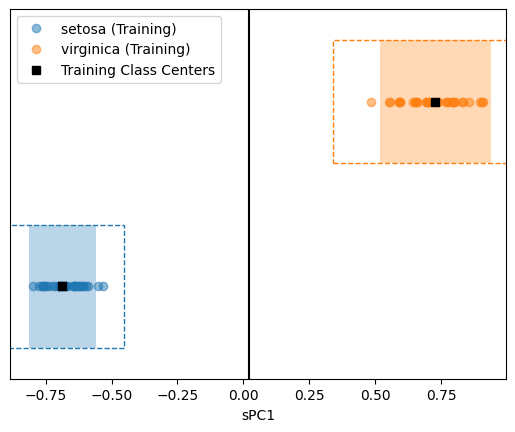

In [31]:
_ = osc.fitted_classification_model.visualize(styles=['hard', 'soft'])

In [32]:
# The predictions can return either OUTLIER (OD identified this point) or UNKNOWN FLOWER (soft model identified this point)

osc.predict(X_train_[:10])

[['setosa'],
 ['OUTLIER'],
 ['setosa'],
 ['virginica'],
 ['UNKNOWN FLOWER'],
 ['virginica'],
 ['OUTLIER'],
 ['virginica'],
 ['setosa'],
 ['setosa']]

In [33]:
# For the purpose of computing metrics these are combined under the OSC's label (here, that is OUTLIER)

res = osc.figures_of_merit(osc.predict(X_train_[:10]), y_train_[:10])
res['CM']

,setosa,virginica,OUTLIER
setosa,4,0,0
virginica,0,3,3


In [34]:
res = osc.figures_of_merit(osc.predict(X_train_), y_train_)
res['CM']

,setosa,virginica,OUTLIER
setosa,33,0,7
virginica,0,32,8


**The difference can be useful if you want to understand which model rejected the point.**

Text(0, 0.5, 'Column 4 (petal width)')

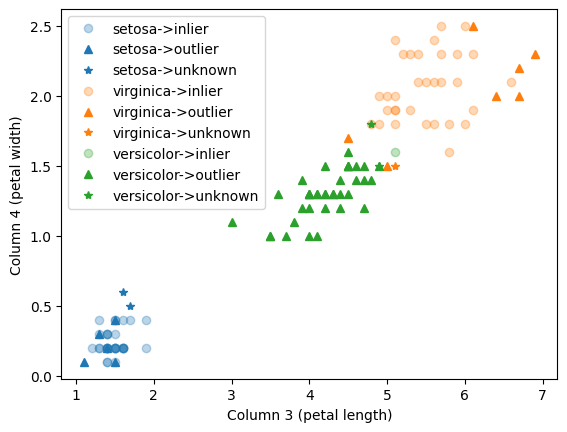

In [36]:
for i, label in enumerate(['setosa', 'virginica', 'versicolor']):
    mask = y_train == label
    X_ = X_train[mask]
    preds_ = osc.predict(X_)

    outlier_mask = np.array([True if x_[0] == 'OUTLIER' else False for x_ in preds_]) # Determined to be OOD by the outlier detector (covariate shift)
    unknown_mask = np.array([True if x_[0] == 'UNKNOWN FLOWER' else False for x_ in preds_]) # PLS-DA determined this was out of its known bounds
    inlier_mask = (~outlier_mask) & (~unknown_mask)

    for mask_, marker_, alpha_, tag_ in zip([inlier_mask, outlier_mask, unknown_mask], ['o', '^', '*'], [0.3, 1.0, 1.0], ['inlier', 'outlier', 'unknown']):
        plt.plot(X_[mask_, 2], X_[mask_, 3], marker=marker_, lw=0, color=f'C{i}', alpha=alpha_, label=f'{label}->{tag_}')

plt.legend(loc='upper left')
plt.xlabel('Column 3 (petal length)')
plt.ylabel('Column 4 (petal width)')

In [37]:
# Note that the trangular points were caught by the outlier detector, but it is possible that the PLS-DA model would
# have caught them too.

clf_, od_, both_, neither_ = 0, 0, 0, 0

od_correct_ = 0
clf_correct_ = 0

for a,b,label in zip(
    osc.fitted_classification_model.predict(X_train),
    osc.fitted_outlier_model.predict(X_train),
    y_train
):
    clf_caught, od_caught = 0, 0
    if a[0] == 'UNKNOWN FLOWER':
        clf_caught = 1
    if b == -1:
        od_caught = 1

    if (a[0] == 'UNKNOWN FLOWER') and (label == 'versicolor'):
        clf_correct_ +=  1

    if (b == -1) and (label == 'versicolor'):
        od_correct_ +=  1

    clf_ += clf_caught
    od_ += od_caught
    both_ += (1 if (clf_caught==1 and od_caught==1) else 0)
    neither_ += (1 if (clf_caught==0 and od_caught==0) else 0)

In [38]:
# In most cases, the model and outlier both reacted the same way to a point.

clf_, od_, both_, neither_

(45, 49, 40, 66)

In [39]:
# They each correctly identified a novel point 37/40 times

clf_correct_, od_correct_

(37, 37)

In [40]:
# The OD rejects 37/40 versicolor points, allowing 3 to get through. However, it is clear that only 1 was incorrectly
# assigned to a known class (virginica); these must have been rejected by the soft PLS-DA model.  Thus, together they
# make a more specific model than either alone (below the PLS-DA model is shown to fail to reject 2 points).

In [41]:
res = osc.figures_of_merit(osc.predict(X_train), y_train)
res['CM']

,setosa,virginica,OUTLIER
setosa,33,0,7
versicolor,0,1,39
virginica,0,32,8


In [42]:
# The PLS-DA model alone is less specific against the versicolor challenge class, however, it is more sensitive to both
# known classes.

soft_plsda = PLSDA(
    **{
        'n_components':3,
        'alpha':0.05,
        'gamma':0.01,
        'style':"soft",
        'not_assigned':"UNKNOWN FLOWER",
        'scale_x':True,
    }
)

_ = soft_plsda.fit(X_train_, y_train_)

res = soft_plsda.figures_of_merit(soft_plsda.predict(X_train), y_train)
res['CM']

,setosa,virginica,UNKNOWN FLOWER
setosa,35,0,5
versicolor,0,2,38
virginica,0,38,2


# Case 3: Convert a Binary OvA Discriminator into a Binary Class Model

Often a single (e.g., authentic) class may be well sampled while many possible alternatives are collected into a single "alternative" class, then a pseudo-binary model is trained in a "one-vs-all" (OvA) fashion.  The lack of a well-defined, well-sampled alternative class is one of the main reasons such models are typically inappropriate for authentication applications. However, it is possible to convert a binary OvA discriminator into a binary class model by adding an outlier detector.  This assumes that the two classes (authentic vs. known alternatives) are well sampled, so that the outlier detector is simply responsible for learning when a covariate shift occurs and a sample moves out of the region of input space that a classifier is expected to be familiar with.  In this sense, we have a model which understands 2 classes: the authentic and the known alternatives, and both class spaces are bounded due to the outlier detector.

By adding an outlier detector, we can at least determine if a new sample looks different from both the known authentic class and the set of known alternatives.  These "unknown unknowns" are typically the reason that models fail under open set conditions.  The example below is not quite an authenticator since it uses both classes to evaluate the model performance, but we may consider it a class model since the outlier detector will reject any sample that is far away from the learned (finite) class space.  Since alternatives are used during training, this is a "compliant" approach rather than a "rigorous" one.

In [43]:
# Pretend that setosa is the target class and virginica is the only known alternative when the model is initially trained.
# For example, perhaps the species is versicolor has not been discovered yet.

target = 'setosa'
known_alternatives = ['virginica'] # In principle, the training set could contain other known alternatives, too
unknown_alternatives = ['versicolor'] # The list of alternatives encountered at test time that were not available during training

mask = (y_train == target) | np.array([y_ in known_alternatives for y_ in y_train])

In [44]:
osc = OpenSetClassifier(
    clf_model=RandomForestClassifier,
    clf_kwargs={
        'n_estimators':100,
        'max_features':'sqrt',
        'random_state':42,
        'class_weight':'balanced'
    },
    outlier_model=IsolationForest,
    outlier_kwargs={
        'n_estimators':100,
        'contamination':0.15, # In practice, this is very important to tune correctly
        'random_state':42,
    },
    inlier_value=1,
    unknown_class='UNKNOWN',
    score_metric='TEFF',
    clf_style='hard',
    score_using="all"
)

In [45]:
osc.fit(X_train[mask], y_train[mask])

OpenSetClassifier(clf_kwargs={'class_weight': 'balanced',
                              'max_features': 'sqrt', 'n_estimators': 100,
                              'random_state': 42},
                  clf_model=<class 'sklearn.ensemble._forest.RandomForestClassifier'>,
                  outlier_kwargs={'contamination': 0.15, 'n_estimators': 100,
                                  'random_state': 42},
                  outlier_model=<class 'sklearn.ensemble._iforest.IsolationForest'>,
                  unknown_class='UNKNOWN')

In [46]:
osc.predict(X_train[mask])[:10]

['setosa',
 'UNKNOWN',
 'setosa',
 'virginica',
 'virginica',
 'virginica',
 'UNKNOWN',
 'UNKNOWN',
 'setosa',
 'setosa']

In [47]:
res = osc.figures_of_merit(osc.predict(X_train[mask]), y_train[mask])
res

{'CM':            setosa  virginica  UNKNOWN
 setosa         36          0        4
 virginica       0         32        8,
 'I': setosa       40
 virginica    40
 dtype: int64,
 'CSNS': setosa       0.9
 virginica    0.8
 dtype: float64,
 'CSPS': setosa       1.0
 virginica    1.0
 dtype: float64,
 'CEFF': setosa       0.948683
 virginica    0.894427
 dtype: float64,
 'TSNS': 0.85,
 'TSPS': 1.0,
 'TEFF': 0.9219544457292888,
 'ACC': 0.85}

In [48]:
res['CM']

,setosa,virginica,UNKNOWN
setosa,36,0,4
virginica,0,32,8


In [49]:
osc.score(X_train, y_train)

0.746473189218623

In [50]:
res = osc.figures_of_merit(osc.predict(X_train), y_train)

In [51]:
res['CM']

,setosa,virginica,UNKNOWN
setosa,36,0,4
versicolor,0,2,38
virginica,0,32,8


# Case 4: Convert a Binary OvA Discriminator into a One-Class Classifier

If we evaluate the model using one-class model metrics we can consider this a one-class classifier (OCC) instead of a binary one.  This effectively still predicts class membership (Y/N) but rejection can come from either the discriminative classifier or the outlier detector.  You can analyze the source of the rejections as previously illustrated with multiclass soft model example.

In [52]:
# Re-label training data into authentic vs. alternative - hold out the versicolor for a later test

def convert_y_to_binary_format(y, target, alternative_class='KNOWN ALTERNATIVE'):
    y_binary = y.copy()
    y_binary[y_binary != target] = alternative_class

    return y_binary

y_train_binary = convert_y_to_binary_format(y_train[mask], target)
X_train_binary = X_train[mask]

In [53]:
y_train_binary[:10]

array(['setosa', 'KNOWN ALTERNATIVE', 'setosa', 'KNOWN ALTERNATIVE',
       'KNOWN ALTERNATIVE', 'KNOWN ALTERNATIVE', 'KNOWN ALTERNATIVE',
       'KNOWN ALTERNATIVE', 'setosa', 'setosa'], dtype=object)

In [54]:
osc = OpenSetClassifier(
    clf_model=RandomForestClassifier,
    clf_kwargs={
        'n_estimators':100,
        'max_features':'sqrt',
        'random_state':42,
        'class_weight':'balanced'
    },
    outlier_model=IsolationForest,
    outlier_kwargs={
        'n_estimators':100,
        'contamination':0.15, # In practice, this is very important to tune correctly
        'random_state':42,
    },
    inlier_value=1,
    unknown_class='UNKNOWN',
    score_metric='TEFF',
    clf_style='hard',
    score_using=target # Now score the model using only the target class as the positive class, others are all negative
)

In [55]:
osc.fit(X_train_binary, y_train_binary)

OpenSetClassifier(clf_kwargs={'class_weight': 'balanced',
                              'max_features': 'sqrt', 'n_estimators': 100,
                              'random_state': 42},
                  clf_model=<class 'sklearn.ensemble._forest.RandomForestClassifier'>,
                  outlier_kwargs={'contamination': 0.15, 'n_estimators': 100,
                                  'random_state': 42},
                  outlier_model=<class 'sklearn.ensemble._iforest.IsolationForest'>,
                  score_using='setosa', unknown_class='UNKNOWN')

In [56]:
osc.score(X_train, y_train)

0.9486832980505138

In [57]:
# Predict on the entire dataset which also includes versicolor as an unknown unknown
res = osc.figures_of_merit(osc.predict(X_train), y_train)

In [58]:
res # The results are now reported as if this is a OCC

{'CM':             KNOWN ALTERNATIVE  setosa  UNKNOWN
 setosa                      0      36        4
 versicolor                  2       0       38
 virginica                  32       0        8,
 'I': KNOWN ALTERNATIVE     0
 setosa               40
 versicolor           40
 virginica            40
 dtype: int64,
 'CSPS': {'KNOWN ALTERNATIVE': nan, 'versicolor': 1.0, 'virginica': 1.0},
 'TSNS': 0.9,
 'TSPS': 1.0,
 'TEFF': 0.9486832980505138,
 'ACC': 0.9666666666666667}

In [59]:
res['CM']

,KNOWN ALTERNATIVE,setosa,UNKNOWN
setosa,0,36,4
versicolor,2,0,38
virginica,32,0,8


In [60]:
tsns = 36 / 40. # 35 correctly recognized as setosa
tsps = (40 + 40) / (40 + 40.) # All others correctly NOT assigned to setosa
teff = (tsns * tsps)**0.5

tsns, tsps, teff

(0.9, 1.0, 0.9486832980505138)

# Case 5: Enabling OCCs to Detect New Alternative Classes

Compliant OCC's contain a bias since they are trained using information about known alternatives.  Rigorous models use only information about the target class.  Compliant models tend to appear more performant on the surface, but the underlying bias is hard to quantify.  Adding an outlier detector to this can help detect covariate shift away from the target + known alternative classes.

In [61]:
osc = OpenSetClassifier(
    clf_model=SIMCA_Authenticator,
    clf_kwargs={
        'n_components':3,
        'alpha':0.05,
        'target_class':target,
        'style':'dd-simca',
        'use':'compliant', # Allows the model to use all classes that make it through the outlier detector
        'scale_x':True,
        'robust':'semi',
        'sft':False,
    },
    outlier_model=IsolationForest,
    outlier_kwargs={
        'n_estimators':100,
        'contamination':0.15, # In practice, this is very important to tune correctly
        'random_state':42,
    },
    inlier_value=1,
    unknown_class="UNKNOWN",
    score_metric='TEFF',
    clf_style='hard', # SIMCA returns Y/N membership which is hard
    score_using=target # Now score the model using only the target class as the positive class, others are all negative
)

In [62]:
osc.fit(X_train_binary, y_train_binary)

OpenSetClassifier(clf_kwargs={'alpha': 0.05, 'n_components': 3,
                              'robust': 'semi', 'scale_x': True, 'sft': False,
                              'style': 'dd-simca', 'target_class': 'setosa',
                              'use': 'compliant'},
                  clf_model=<class 'pychemauth.classifier.simca.SIMCA_Authenticator'>,
                  outlier_kwargs={'contamination': 0.15, 'n_estimators': 100,
                                  'random_state': 42},
                  outlier_model=<class 'sklearn.ensemble._iforest.IsolationForest'>,
                  score_using='setosa', unknown_class='UNKNOWN')

In [63]:
# OCC predict T/F while OD returns "UNKNOWN" string, so let's convert this to the same format.

def convert_predictions_to_occ(X, target, alternative_class='KNOWN ALTERNATIVE'):
    pred_ = osc.predict(X)
    preds = []
    for i in range(len(pred_)):
        if pred_[i] == True:
            preds.append(target)
        elif pred_[i] == False:
            preds.append(alternative_class)
        else:
            preds.append(pred_[i])

    return preds

In [64]:
# 2 versicolor were (incorrectly) considered to belong to a known alternative (virginica), but most were classified as
# entirely novel (UNKNOWN) by the outlier detector!  The virginica were mostly recognized correctly as a known alternative.

res = osc.figures_of_merit(convert_predictions_to_occ(X_train, target), y_train)
res['CM']

,KNOWN ALTERNATIVE,setosa,UNKNOWN
setosa,6,30,4
versicolor,2,0,38
virginica,32,0,8


In [65]:
tsns = 30 / 40.
tsps = (40 + 40) / 80.
acc = (30 + (2+38) + (32+8)) / (40 + 40 + 40.)
tsns, tsps, acc

(0.75, 1.0, 0.9166666666666666)

In [66]:
res

{'CM':             KNOWN ALTERNATIVE  setosa  UNKNOWN
 setosa                      6      30        4
 versicolor                  2       0       38
 virginica                  32       0        8,
 'I': KNOWN ALTERNATIVE     0
 setosa               40
 versicolor           40
 virginica            40
 dtype: int64,
 'CSPS': {'KNOWN ALTERNATIVE': nan, 'versicolor': 1.0, 'virginica': 1.0},
 'TSNS': 0.75,
 'TSPS': 1.0,
 'TEFF': 0.8660254037844386,
 'ACC': 0.9166666666666666}

# Common pitfalls

Some things to keep in mind:

1. It is typically best to allow the OpenSetClassifier to infer the known classes from the training data.  If you manually specify this and forget some classes, those points which belong to those left out will be ignored during training.  This also affects the way the model is scored.
